# Ejercicios

Para los siguientes puntos, utilizar la librería [RAPIDS](https://rapids.ai/) a la hora de implementar los algoritmos estudiados, en caso de estar disponibles.

- Realice una comparación de los métodos de clustering vistos, para generar una segmentación de imagen a color, incluyendo la información de ubicación de cada pixel (ver Cuaderno guía [tanjiro](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/tanjiro.ipynb)). Varie la cantidad de grupos (niveles o clases de segmentación) $k\in\{3,5,7,9\}$ y presente los scores de inercia y silueta conseguidos.

- Repita el punto anterior realizando una proyección 2D de los datos con PCA y UMAP (ver guía [reducción de dimensión](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/8_ReduccionDimension.ipynb))
 antes de generar las segmentaciones.

In [10]:
#https://drive.google.com/file/d/1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP/view?usp=sharing

FILEID = "1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O tanjiro.jpeg && rm -rf /tmp/cookies.txt

--2025-06-12 17:39:00--  https://docs.google.com/uc?export=download&confirm=&id=1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP
Resolving docs.google.com (docs.google.com)... 74.125.200.139, 74.125.200.113, 74.125.200.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.200.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP&export=download [following]
--2025-06-12 17:39:01--  https://drive.usercontent.google.com/download?id=1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.175.132, 2404:6800:4003:c1c::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.175.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6476 (6.3K) [image/jpeg]
Saving to: ‘tanjiro.jpeg’

tanjiro.jpeg        100%[===================>]   6.32K  --.-KB/s    in 0s    

(125, 125, 3)

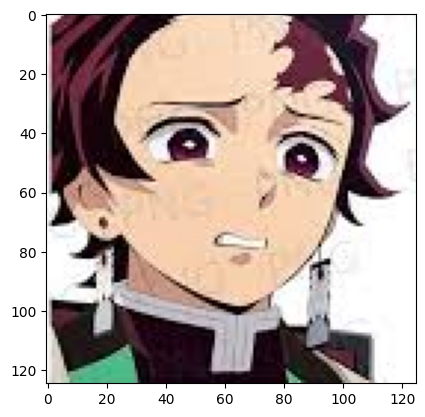

In [11]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
image = imread(os.path.join("tanjiro.jpeg"))
image = image[50:175,50:175,:]
plt.imshow(image)
image.shape

In [12]:
# Obtener las dimensiones de la imagen
height, width, channels = image.shape

# Creamos una grilla con las coordenadas x e y de cada pixel
x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))

# Aplanamos todas las matrices para convertirlas en vectores
x_flat = x_coords.flatten()
y_flat = y_coords.flatten()
r_flat = image[:, :, 0].flatten()
g_flat = image[:, :, 1].flatten()
b_flat = image[:, :, 2].flatten()

# Concatenamos todo en una sola matriz de características
X = np.stack([x_flat, y_flat, r_flat, g_flat, b_flat], axis=1)

print(f"Shape de la matriz de entrada para clustering: {X.shape}")

Shape de la matriz de entrada para clustering: (15625, 5)


In [13]:
import cuml
print('cuml:',cuml.__version__)

cuml: 25.02.01


In [14]:
from cuml.cluster import KMeans
import cupy as cp

In [15]:
# Convertir X (numpy) a cupy (necesario para RAPIDS)
X_gpu = cp.asarray(X)

# Aplicar KMeans con k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_gpu)

# Obtener las etiquetas (en GPU) y traerlas a CPU
labels = cp.asnumpy(kmeans.labels_)

# Imprimir la inercia (distancia interna a centroides)
print(f"Inercia: {kmeans.inertia_}\n\n")

Inercia: 68630768.0




/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


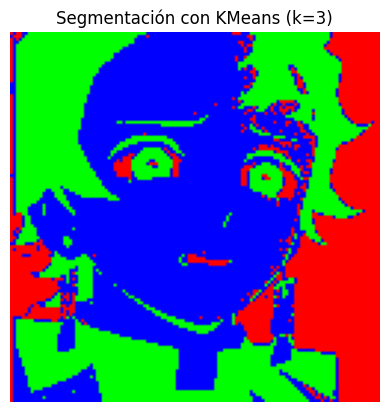

In [16]:
# Mapa de colores para cada cluster
colors = np.array([
    [255, 0, 0],    # Rojo
    [0, 255, 0],    # Verde
    [0, 0, 255],    # Azul
    # Puedes agregar más si k > 3
]) / 255.0

# Asignamos el color del cluster a cada píxel
segmented_img = colors[labels].reshape((height, width, 3))

# Mostrar imagen segmentada
plt.imshow(segmented_img)
plt.title("Segmentación con KMeans (k=3)")
plt.axis("off")
plt.show()


# KMeans

In [17]:
from cuml.metrics.cluster import silhouette_score

ks = [3, 5, 7, 9]
inertias = []
silhouettes = []

# Convertir los datos a cupy
X_gpu = cp.asarray(X)

for k in ks:
    print(f"\nEntrenando KMeans con k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_gpu)

    # Inercia
    inertia = float(kmeans.inertia_)
    inertias.append(inertia)
    print(f"Inercia: {inertia}")

    # Silueta (puede demorar)
    try:
        silhouette = float(silhouette_score(X_gpu, kmeans.labels_))
        silhouettes.append(silhouette)
        print(f"Silhouette Score: {silhouette}")
    except Exception as e:
        silhouettes.append(np.nan)
        print(f"No se pudo calcular silueta: {e}")



Entrenando KMeans con k=3...
Inercia: 68630768.0
Silhouette Score: 0.4701918363571167

Entrenando KMeans con k=5...
Inercia: 44177904.0
Silhouette Score: 0.3983147144317627

Entrenando KMeans con k=7...
Inercia: 33659204.0
Silhouette Score: 0.41810187697410583

Entrenando KMeans con k=9...
Inercia: 27954524.0
Silhouette Score: 0.3798421323299408


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


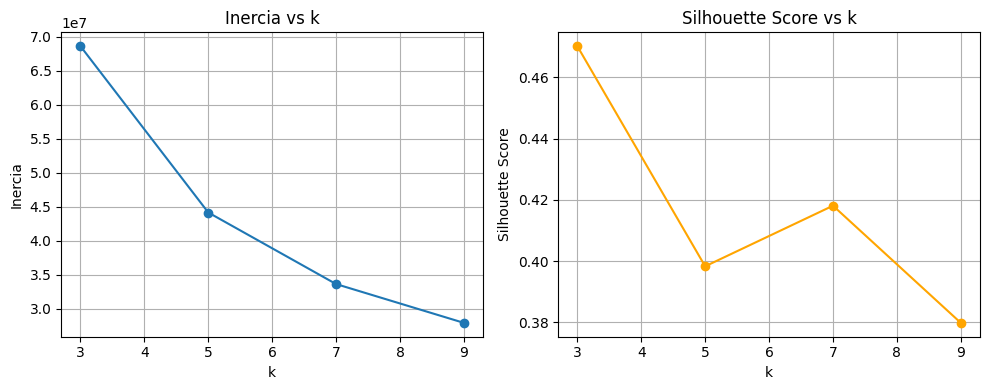

In [18]:
plt.figure(figsize=(10,4))

# Inercia
plt.subplot(1, 2, 1)
plt.plot(ks, inertias, marker='o', label='Inercia')
plt.title("Inercia vs k")
plt.xlabel("k")
plt.ylabel("Inercia")
plt.grid(True)

# Silueta
plt.subplot(1, 2, 2)
plt.plot(ks, silhouettes, marker='o', color='orange', label='Silhouette')
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


### 📊 Resultados de segmentación con KMeans

### ✅ Conclusión

La curva de inercia muestra un descenso progresivo a medida que se incrementa el número de clusters `k`, lo cual era de esperarse: al aumentar `k`, cada grupo tiene menos puntos y puede ajustarse mejor localmente, reduciendo la distancia a sus centroides. Sin embargo, esta métrica no penaliza el sobreajuste, por lo que por sí sola no basta para elegir el valor óptimo de `k`.

Por otro lado, el score de silueta alcanza su valor máximo en `k = 3` (`0.47`), y decrece para valores mayores de `k`, indicando que la separación entre los grupos es más clara cuando se divide la imagen en solo tres regiones. Esto sugiere que `k = 3` ofrece un buen equilibrio entre cohesión interna y separación externa, y es una buena elección para segmentar esta imagen con KMeans.


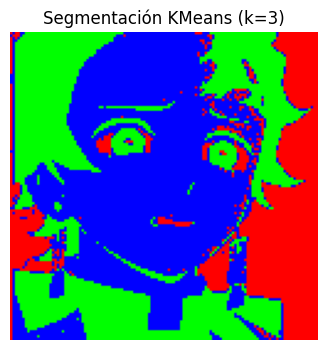

In [19]:
k_best = 3
kmeans_best = KMeans(n_clusters=k_best, random_state=42)
kmeans_best.fit(X_gpu)

labels_best = cp.asnumpy(kmeans_best.labels_)

# Mapa de colores para cada cluster (puedes personalizar)
colors = np.array([
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
]) / 255.0

# Crear imagen segmentada
segmented_img = colors[labels_best].reshape((height, width, 3))

# Mostrar
plt.figure(figsize=(4, 4))
plt.imshow(segmented_img)
plt.title(f"Segmentación KMeans (k={k_best})")
plt.axis("off")
plt.show()


### 🤖 Conclusión: KMeans

El algoritmo KMeans mostró un comportamiento esperado: a medida que aumentó el número de clusters `k`, la inercia disminuyó, indicando mejor ajuste interno. Sin embargo, el score de silueta fue mayor con `k = 3`, sugiriendo que con tres segmentos se obtiene una mejor separación entre regiones de la imagen.

Esto se refleja visualmente en una segmentación limpia y coherente, en la que los grupos representan zonas homogéneas bien diferenciadas. Por tanto, `k = 3` fue seleccionado como el valor óptimo para este algoritmo.


# MiniBatchKMeans

In [20]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np

ks = [3, 5, 7, 9]
inertias_mb = []
silhouettes_mb = []
labels_dict_mb = {}

for k in ks:
    print(f"\nEntrenando MiniBatchKMeans con k={k}...")
    mbk = MiniBatchKMeans(n_clusters=k, batch_size=1024, random_state=42)
    mbk.fit(X)

    inertia = mbk.inertia_
    inertias_mb.append(inertia)

    labels = mbk.labels_
    score = silhouette_score(X, labels)
    silhouettes_mb.append(score)

    labels_dict_mb[k] = labels  # Guardamos para usar luego

    print(f"Inercia: {inertia:.2f}")
    print(f"Silhouette Score: {score:.4f}")


Entrenando MiniBatchKMeans con k=3...
Inercia: 70191862.77
Silhouette Score: 0.4564

Entrenando MiniBatchKMeans con k=5...
Inercia: 49519927.49
Silhouette Score: 0.3971

Entrenando MiniBatchKMeans con k=7...
Inercia: 34503242.27
Silhouette Score: 0.3488

Entrenando MiniBatchKMeans con k=9...
Inercia: 28954243.77
Silhouette Score: 0.3894


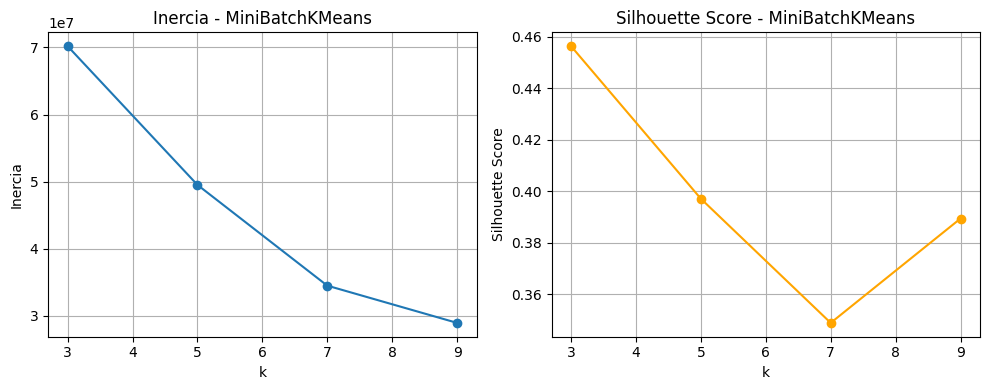

In [21]:
plt.figure(figsize=(10, 4))

# Inercia
plt.subplot(1, 2, 1)
plt.plot(ks, inertias_mb, marker='o')
plt.title("Inercia - MiniBatchKMeans")
plt.xlabel("k")
plt.ylabel("Inercia")
plt.grid(True)

# Silueta
plt.subplot(1, 2, 2)
plt.plot(ks, silhouettes_mb, marker='o', color='orange')
plt.title("Silhouette Score - MiniBatchKMeans")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


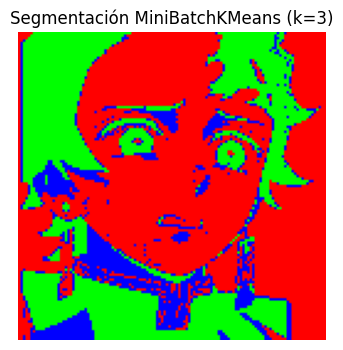

In [22]:
# Obtener mejor k según silueta
best_k_mb = ks[np.argmax(silhouettes_mb)]
best_labels_mb = labels_dict_mb[best_k_mb]

# Usamos la misma paleta de colores
colors = np.array([
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
    [255, 255, 0],
    [255, 0, 255],
    [0, 255, 255],
    [128, 128, 128],
    [255, 128, 0],
    [0, 128, 255],
]) / 255.0

segmented_mb = colors[best_labels_mb].reshape((height, width, 3))

plt.figure(figsize=(4, 4))
plt.imshow(segmented_mb)
plt.title(f"Segmentación MiniBatchKMeans (k={best_k_mb})")
plt.axis("off")
plt.show()

### 🤖 Conclusión: MiniBatchKMeans

MiniBatchKMeans mostró un comportamiento consistente con lo esperado: la inercia disminuyó conforme aumentó el número de clusters `k`, lo cual indica un mejor ajuste interno. Sin embargo, el score de silueta fue mayor con `k = 3` (0.4564), y decreció al aumentar `k`, lo que sugiere que las segmentaciones se vuelven menos separables y más ruidosas con más grupos.

Aunque MiniBatchKMeans es una versión aproximada y más rápida de KMeans, logró resultados muy similares al algoritmo completo, especialmente en términos de silhouette. Esto lo convierte en una buena alternativa cuando se trabaja con conjuntos de datos más grandes o en tiempo real.


# DBScan

In [23]:
from sklearn.cluster import DBSCAN

eps_values = [1.5, 2.0, 2.5, 3.0]
silhouettes_dbscan = []
n_clusters_list = []
labels_dict_dbscan = {}

for eps in eps_values:
    print(f"\nEntrenando DBSCAN con eps={eps}...")
    db = DBSCAN(eps=eps, min_samples=10)
    db.fit(X)

    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_list.append(n_clusters)

    if n_clusters > 1:
        score = silhouette_score(X, labels)
        silhouettes_dbscan.append(score)
        print(f"Clusters encontrados: {n_clusters}, Silhouette Score: {score:.4f}")
    else:
        silhouettes_dbscan.append(np.nan)
        print(f"Solo un cluster encontrado o todos ruido.")

    labels_dict_dbscan[eps] = labels



Entrenando DBSCAN con eps=1.5...
Solo un cluster encontrado o todos ruido.

Entrenando DBSCAN con eps=2.0...
Clusters encontrados: 27, Silhouette Score: -0.3337

Entrenando DBSCAN con eps=2.5...
Clusters encontrados: 24, Silhouette Score: -0.5287

Entrenando DBSCAN con eps=3.0...
Clusters encontrados: 28, Silhouette Score: -0.5586


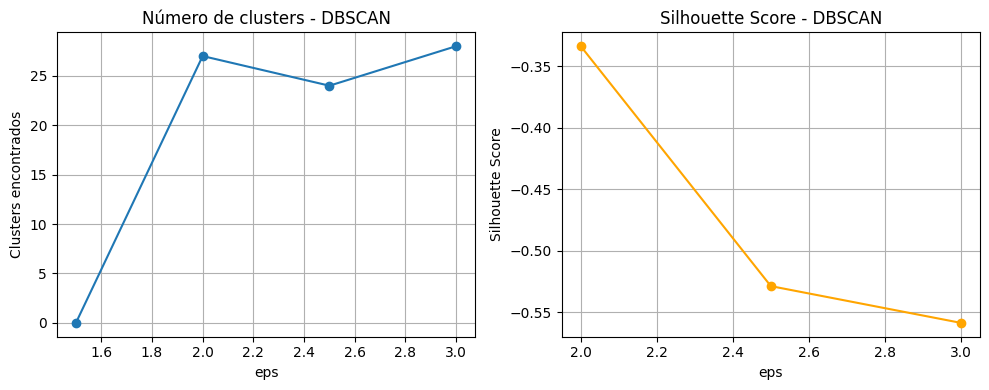

In [24]:
plt.figure(figsize=(10, 4))

# Número de clusters
plt.subplot(1, 2, 1)
plt.plot(eps_values, n_clusters_list, marker='o')
plt.title("Número de clusters - DBSCAN")
plt.xlabel("eps")
plt.ylabel("Clusters encontrados")
plt.grid(True)

# Silueta
plt.subplot(1, 2, 2)
plt.plot(eps_values, silhouettes_dbscan, marker='o', color='orange')
plt.title("Silhouette Score - DBSCAN")
plt.xlabel("eps")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


<ipython-input-25-1937499624>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_labels + 1)


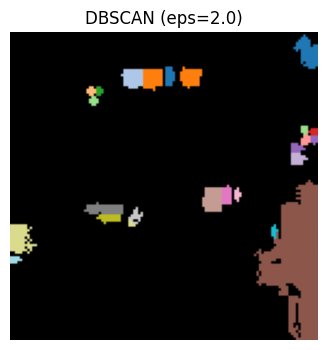

In [25]:
labels_dbscan = labels_dict_dbscan[2.0]
n_labels = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)

# Creamos una paleta extendida para hasta 30 clusters
from matplotlib import cm
cmap = cm.get_cmap('tab20', n_labels + 1)
colors = cmap(np.linspace(0, 1, n_labels + 1))[:, :3]

# Reemplazamos ruido (-1) por negro
colored_labels = np.array([colors[label] if label != -1 else [0, 0, 0] for label in labels_dbscan])

# Reshape a imagen
segmented_dbscan = colored_labels.reshape((height, width, 3))

plt.figure(figsize=(4, 4))
plt.imshow(segmented_dbscan)
plt.title("DBSCAN (eps=2.0)")
plt.axis("off")
plt.show()


### 🤖 Conclusión: DBSCAN

DBSCAN no logró segmentar adecuadamente la imagen en este experimento. Para `eps = 1.5`, detectó solo un cluster (o consideró todos los puntos como ruido), y para valores mayores (`eps ∈ {2.0, 2.5, 3.0}`), detectó entre 24 y 28 grupos, pero con scores de silueta negativos, lo que indica una segmentación de muy baja calidad.

Esto sugiere que DBSCAN no es una opción adecuada para este tipo de datos, donde los puntos (píxeles) están densamente distribuidos y forman transiciones suaves de color y ubicación. A diferencia de métodos basados en centroides como KMeans, DBSCAN tiende a fragmentar la imagen en regiones muy pequeñas y caóticas.


# SpectralClustering

In [26]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

ks = [3, 5, 7, 9]
silhouettes_spec = []
labels_dict_spec = {}

for k in ks:
    print(f"\nEntrenando SpectralClustering con k={k}...")
    sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42, n_jobs=-1)
    labels = sc.fit_predict(X)

    score = silhouette_score(X, labels)
    silhouettes_spec.append(score)
    labels_dict_spec[k] = labels

    print(f"Silhouette Score: {score:.4f}")



Entrenando SpectralClustering con k=3...
Silhouette Score: 0.4688

Entrenando SpectralClustering con k=5...
Silhouette Score: 0.2861

Entrenando SpectralClustering con k=7...
Silhouette Score: 0.3230

Entrenando SpectralClustering con k=9...
Silhouette Score: 0.3345


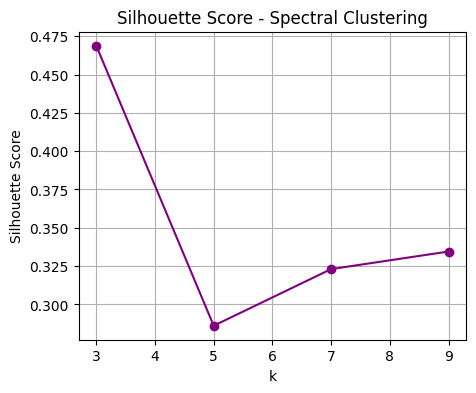

In [27]:
plt.figure(figsize=(5, 4))
plt.plot(ks, silhouettes_spec, marker='o', color='purple')
plt.title("Silhouette Score - Spectral Clustering")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

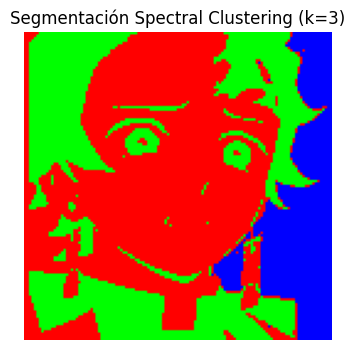

In [28]:
labels_spec = labels_dict_spec[3]

# Usamos los mismos 3 colores que antes
colors = np.array([
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
]) / 255.0

segmented_spec = colors[labels_spec].reshape((height, width, 3))

plt.figure(figsize=(4, 4))
plt.imshow(segmented_spec)
plt.title("Segmentación Spectral Clustering (k=3)")
plt.axis("off")
plt.show()


### 🤖 Conclusión: Spectral Clustering

Spectral Clustering alcanzó su mejor desempeño con `k = 3`, obteniendo un score de silueta de `0.4688`, comparable al de KMeans. Para valores mayores de `k`, la calidad de la segmentación disminuyó notablemente, con scores por debajo de `0.35`.

Esto sugiere que, aunque Spectral Clustering puede capturar relaciones más complejas entre píxeles mediante una representación basada en grafos, en este caso no ofreció una ventaja significativa sobre métodos más simples como KMeans. Dado su alto costo computacional y resultados similares, puede no ser la opción más eficiente para este tipo de segmentación.


# PCA + KMeans

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

print(f"X_pca shape: {X_pca.shape}")

X_pca shape: (15625, 2)


In [30]:
ks = [3, 5, 7, 9]
inertias_pca = []
silhouettes_pca = []
labels_dict_pca = {}

for k in ks:
    print(f"\nKMeans sobre PCA con k={k}...")
    kmeans_pca = KMeans(n_clusters=k, random_state=42)
    kmeans_pca.fit(X_pca)

    inertia = kmeans_pca.inertia_
    score = silhouette_score(X_pca, kmeans_pca.labels_)

    inertias_pca.append(inertia)
    silhouettes_pca.append(score)
    labels_dict_pca[k] = kmeans_pca.labels_

    print(f"Inercia: {inertia:.2f}")
    print(f"Silhouette Score: {score:.4f}")



KMeans sobre PCA con k=3...


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Inercia: 46156840.76
Silhouette Score: 0.5395

KMeans sobre PCA con k=5...


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Inercia: 24125698.46
Silhouette Score: 0.4915

KMeans sobre PCA con k=7...


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Inercia: 15323784.93
Silhouette Score: 0.4698

KMeans sobre PCA con k=9...


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Inercia: 12436985.11
Silhouette Score: 0.4683


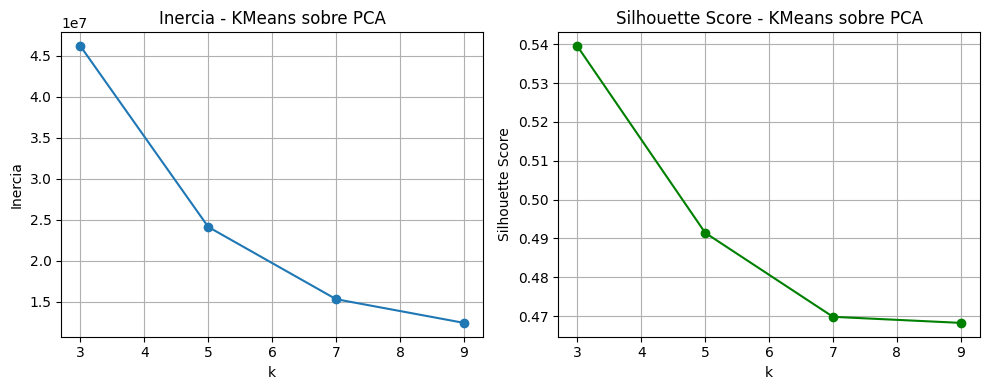

In [31]:
plt.figure(figsize=(10, 4))

# Inercia
plt.subplot(1, 2, 1)
plt.plot(ks, inertias_pca, marker='o')
plt.title("Inercia - KMeans sobre PCA")
plt.xlabel("k")
plt.ylabel("Inercia")
plt.grid(True)

# Silueta
plt.subplot(1, 2, 2)
plt.plot(ks, silhouettes_pca, marker='o', color='green')
plt.title("Silhouette Score - KMeans sobre PCA")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()

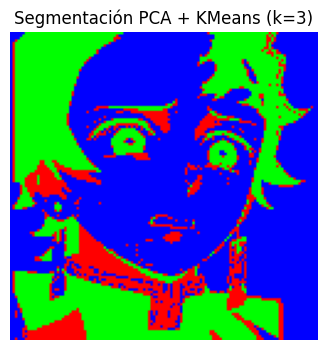

In [32]:
best_k_pca = 3
labels_pca = labels_dict_pca[best_k_pca]

# Paleta para 3 clusters
colors = np.array([
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
]) / 255.0

segmented_pca = colors[labels_pca].reshape((height, width, 3))

plt.figure(figsize=(4, 4))
plt.imshow(segmented_pca)
plt.title("Segmentación PCA + KMeans (k=3)")
plt.axis("off")
plt.show()

### 🤖 Conclusión: KMeans sobre PCA

Aplicar PCA antes de KMeans resultó beneficioso para este caso. El score de silueta fue más alto que en el espacio original, alcanzando un valor de `0.5395` para `k = 3`, frente a `0.4702` sin reducción de dimensión. Esto indica que la proyección en dos dimensiones preservó suficientemente bien las relaciones espaciales y de color entre los píxeles, y permitió una segmentación más clara.

Además, esta reducción a 2D puede acelerar los algoritmos de clustering y facilitar su visualización. En conjunto, PCA + KMeans es una combinación eficiente y eficaz para este tipo de segmentación de imágenes.


# PCA + MiniBatchKMeans

In [33]:
from sklearn.cluster import MiniBatchKMeans

ks = [3, 5, 7, 9]
inertias_pca_mb = []
silhouettes_pca_mb = []
labels_dict_pca_mb = {}

for k in ks:
    print(f"\nMiniBatchKMeans sobre PCA con k={k}...")
    mbk_pca = MiniBatchKMeans(n_clusters=k, batch_size=1024, random_state=42)
    mbk_pca.fit(X_pca)

    inertia = mbk_pca.inertia_
    score = silhouette_score(X_pca, mbk_pca.labels_)

    inertias_pca_mb.append(inertia)
    silhouettes_pca_mb.append(score)
    labels_dict_pca_mb[k] = mbk_pca.labels_

    print(f"Inercia: {inertia:.2f}")
    print(f"Silhouette Score: {score:.4f}")



MiniBatchKMeans sobre PCA con k=3...
Inercia: 46196780.26
Silhouette Score: 0.5444

MiniBatchKMeans sobre PCA con k=5...
Inercia: 24148471.92
Silhouette Score: 0.4912

MiniBatchKMeans sobre PCA con k=7...
Inercia: 16366808.56
Silhouette Score: 0.4851

MiniBatchKMeans sobre PCA con k=9...
Inercia: 13040141.99
Silhouette Score: 0.4448


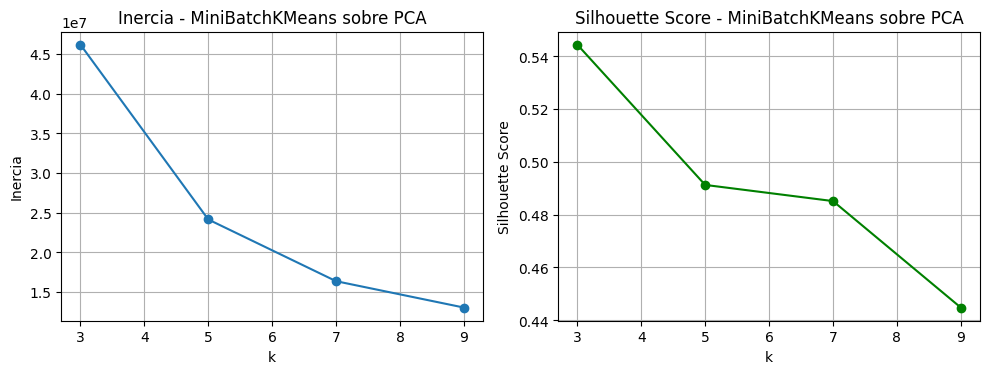

In [34]:
plt.figure(figsize=(10, 4))

# Inercia
plt.subplot(1, 2, 1)
plt.plot(ks, inertias_pca_mb, marker='o')
plt.title("Inercia - MiniBatchKMeans sobre PCA")
plt.xlabel("k")
plt.ylabel("Inercia")
plt.grid(True)

# Silueta
plt.subplot(1, 2, 2)
plt.plot(ks, silhouettes_pca_mb, marker='o', color='green')
plt.title("Silhouette Score - MiniBatchKMeans sobre PCA")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


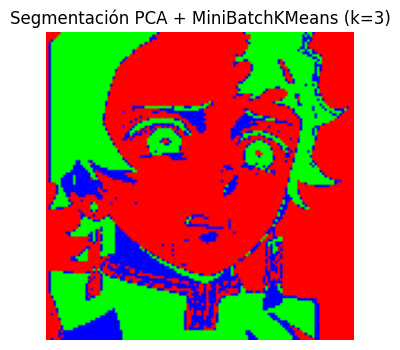

In [35]:
best_k_pca_mb = 3
labels_pca_mb = labels_dict_pca_mb[best_k_pca_mb]

# Paleta
colors = np.array([
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
]) / 255.0

segmented_pca_mb = colors[labels_pca_mb].reshape((height, width, 3))

plt.figure(figsize=(4, 4))
plt.imshow(segmented_pca_mb)
plt.title("Segmentación PCA + MiniBatchKMeans (k=3)")
plt.axis("off")
plt.show()


### 🤖 Conclusión: MiniBatchKMeans sobre PCA

MiniBatchKMeans aplicado sobre los datos reducidos con PCA logró su mejor desempeño con `k = 3`, obteniendo un score de silueta de `0.5444`. Este valor supera incluso al obtenido por KMeans, lo que indica que esta combinación logra una segmentación nítida y bien separada en el espacio reducido.

Además de ser más eficiente computacionalmente, MiniBatchKMeans demostró que puede mantener una alta calidad de agrupamiento, especialmente cuando se utiliza una representación compacta como la que ofrece PCA. Por tanto, esta configuración es especialmente atractiva para segmentaciones rápidas sobre imágenes con muchos píxeles.


# PCA + DBScan

In [36]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

eps_values = [1.0, 1.5, 2.0, 2.5]
silhouettes_pca_dbscan = []
n_clusters_pca_dbscan = []
labels_dict_pca_dbscan = {}

for eps in eps_values:
    print(f"\nDBSCAN sobre PCA con eps={eps}...")
    db = DBSCAN(eps=eps, min_samples=10)
    db.fit(X_pca)

    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_pca_dbscan.append(n_clusters)

    if n_clusters > 1:
        score = silhouette_score(X_pca, labels)
        silhouettes_pca_dbscan.append(score)
        print(f"Clusters encontrados: {n_clusters}, Silhouette Score: {score:.4f}")
    else:
        silhouettes_pca_dbscan.append(np.nan)
        print(f"Solo un cluster encontrado o todos ruido.")

    labels_dict_pca_dbscan[eps] = labels



DBSCAN sobre PCA con eps=1.0...
Clusters encontrados: 61, Silhouette Score: -0.6445

DBSCAN sobre PCA con eps=1.5...
Clusters encontrados: 75, Silhouette Score: -0.5102

DBSCAN sobre PCA con eps=2.0...
Clusters encontrados: 68, Silhouette Score: -0.4044

DBSCAN sobre PCA con eps=2.5...
Clusters encontrados: 61, Silhouette Score: -0.3897


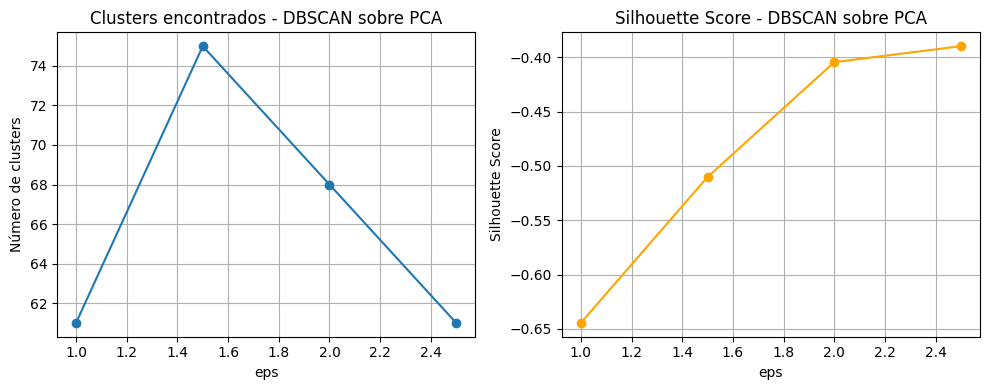

In [37]:
plt.figure(figsize=(10, 4))

# Clusters
plt.subplot(1, 2, 1)
plt.plot(eps_values, n_clusters_pca_dbscan, marker='o')
plt.title("Clusters encontrados - DBSCAN sobre PCA")
plt.xlabel("eps")
plt.ylabel("Número de clusters")
plt.grid(True)

# Silueta
plt.subplot(1, 2, 2)
plt.plot(eps_values, silhouettes_pca_dbscan, marker='o', color='orange')
plt.title("Silhouette Score - DBSCAN sobre PCA")
plt.xlabel("eps")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


### 🤖 Conclusión: DBSCAN sobre PCA

A pesar de aplicar reducción de dimensión con PCA, DBSCAN no logró segmentar correctamente la imagen. Detectó entre 61 y 75 clusters con todos los valores de `eps` probados, lo cual indica una sobresegmentación severa. Además, todos los silhouette scores fueron negativos, siendo el mejor apenas `-0.3897`, lo que sugiere que los grupos están mal definidos.

Estos resultados confirman que DBSCAN no es una buena opción para este tipo de segmentación, ya que tiende a formar regiones pequeñas


# PCA + Spectral Clustering

In [38]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

ks = [3, 5, 7, 9]
silhouettes_pca_spec = []
labels_dict_pca_spec = {}

for k in ks:
    print(f"\nSpectral Clustering sobre PCA con k={k}...")
    sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42, n_jobs=-1)
    labels = sc.fit_predict(X_pca)

    score = silhouette_score(X_pca, labels)
    silhouettes_pca_spec.append(score)
    labels_dict_pca_spec[k] = labels

    print(f"Silhouette Score: {score:.4f}")


Spectral Clustering sobre PCA con k=3...
Silhouette Score: 0.5015

Spectral Clustering sobre PCA con k=5...
Silhouette Score: 0.3789

Spectral Clustering sobre PCA con k=7...
Silhouette Score: 0.3749

Spectral Clustering sobre PCA con k=9...
Silhouette Score: 0.4286


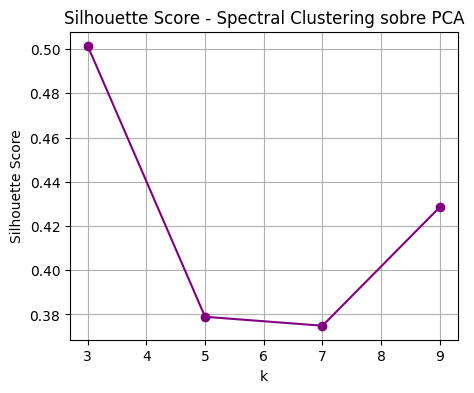

In [39]:
plt.figure(figsize=(5, 4))
plt.plot(ks, silhouettes_pca_spec, marker='o', color='purple')
plt.title("Silhouette Score - Spectral Clustering sobre PCA")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

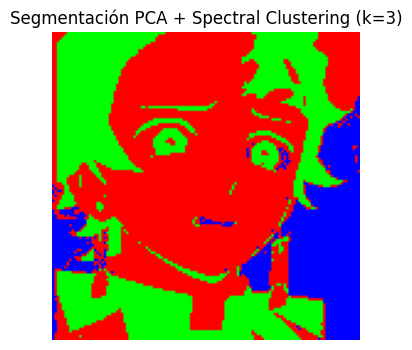

In [40]:
best_k_pca_spec = 3
labels_pca_spec = labels_dict_pca_spec[best_k_pca_spec]

colors = np.array([
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
]) / 255.0

segmented_pca_spec = colors[labels_pca_spec].reshape((height, width, 3))

plt.figure(figsize=(4, 4))
plt.imshow(segmented_pca_spec)
plt.title("Segmentación PCA + Spectral Clustering (k=3)")
plt.axis("off")
plt.show()


### 🤖 Conclusión: Spectral Clustering sobre PCA

Al aplicar Spectral Clustering sobre los datos proyectados con PCA, se observó una mejora notable respecto al espacio original. El mejor resultado se obtuvo con `k = 3`, alcanzando un silhouette score de `0.5015`, superior al obtenido en 5 dimensiones (`0.4688`). Esto sugiere que la reducción de dimensión ayuda a este algoritmo a construir un grafo más representativo y mejorar la asignación de clusters.

No obstante, a pesar de esta mejora, los resultados siguen siendo inferiores a los obtenidos por KMeans y MiniBatchKMeans en PCA, tanto en calidad de segmentación como en eficiencia computacional. Por lo tanto, aunque Spectral puede capturar relaciones no lineales, no aporta beneficios suficientes frente a métodos más simples en este contexto.


# UMAP + KMeans

In [41]:
from umap import UMAP

umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X)

print(f"X_umap shape: {X_umap.shape}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


X_umap shape: (15625, 2)


In [42]:
ks = [3, 5, 7, 9]
inertias_umap = []
silhouettes_umap = []
labels_dict_umap = {}

for k in ks:
    print(f"\nKMeans sobre UMAP con k={k}...")
    kmeans_umap = KMeans(n_clusters=k, random_state=42)
    kmeans_umap.fit(X_umap)

    inertia = kmeans_umap.inertia_
    score = silhouette_score(X_umap, kmeans_umap.labels_)

    inertias_umap.append(inertia)
    silhouettes_umap.append(score)
    labels_dict_umap[k] = kmeans_umap.labels_

    print(f"Inercia: {inertia:.2f}")
    print(f"Silhouette Score: {score:.4f}")



KMeans sobre UMAP con k=3...


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Inercia: 464440.44
Silhouette Score: 0.4492

KMeans sobre UMAP con k=5...


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Inercia: 281572.69
Silhouette Score: 0.3870

KMeans sobre UMAP con k=7...


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Inercia: 174634.16
Silhouette Score: 0.4397

KMeans sobre UMAP con k=9...


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Inercia: 130114.11
Silhouette Score: 0.4285


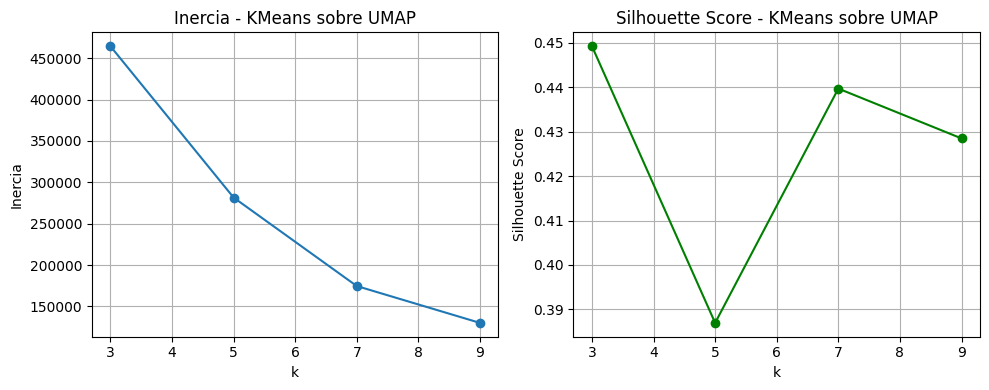

In [43]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(ks, inertias_umap, marker='o')
plt.title("Inercia - KMeans sobre UMAP")
plt.xlabel("k")
plt.ylabel("Inercia")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ks, silhouettes_umap, marker='o', color='green')
plt.title("Silhouette Score - KMeans sobre UMAP")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


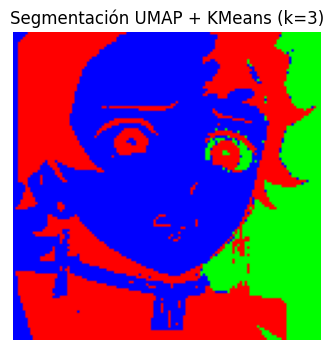

In [44]:
best_k_umap = 3
labels_umap = labels_dict_umap[best_k_umap]

colors = np.array([
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
]) / 255.0

segmented_umap = colors[labels_umap].reshape((height, width, 3))

plt.figure(figsize=(4, 4))
plt.imshow(segmented_umap)
plt.title("Segmentación UMAP + KMeans (k=3)")
plt.axis("off")
plt.show()

### 🤖 Conclusión: KMeans sobre UMAP

Aplicar UMAP antes de KMeans logró resultados sólidos, aunque ligeramente inferiores a los obtenidos con PCA. El mejor silhouette score fue `0.4492` con `k = 3`, pero valores cercanos se mantuvieron con `k = 7` y `k = 9`, mostrando cierta estabilidad en la segmentación.

UMAP puede captar estructuras no lineales mejor que PCA, pero también introduce más variabilidad debido a su naturaleza estocástica. En este caso, su ventaja estructural no se tradujo en una mejora sustancial en la segmentación, por lo que PCA sigue siendo preferible cuando se busca simplicidad y robustez.


# UMAP + MiniBatchKMeans

In [45]:
ks = [3, 5, 7, 9]
inertias_umap_mb = []
silhouettes_umap_mb = []
labels_dict_umap_mb = {}

for k in ks:
    print(f"\nMiniBatchKMeans sobre UMAP con k={k}...")
    mbk_umap = MiniBatchKMeans(n_clusters=k, batch_size=1024, random_state=42)
    mbk_umap.fit(X_umap)

    inertia = mbk_umap.inertia_
    score = silhouette_score(X_umap, mbk_umap.labels_)

    inertias_umap_mb.append(inertia)
    silhouettes_umap_mb.append(score)
    labels_dict_umap_mb[k] = mbk_umap.labels_

    print(f"Inercia: {inertia:.2f}")
    print(f"Silhouette Score: {score:.4f}")



MiniBatchKMeans sobre UMAP con k=3...
Inercia: 464611.91
Silhouette Score: 0.4500

MiniBatchKMeans sobre UMAP con k=5...
Inercia: 288008.47
Silhouette Score: 0.3762

MiniBatchKMeans sobre UMAP con k=7...
Inercia: 199219.59
Silhouette Score: 0.3992

MiniBatchKMeans sobre UMAP con k=9...
Inercia: 132500.05
Silhouette Score: 0.4557


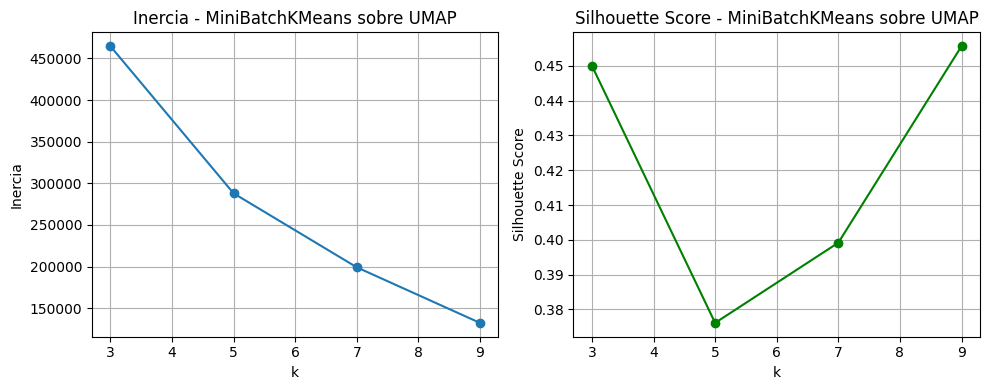

In [46]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(ks, inertias_umap_mb, marker='o')
plt.title("Inercia - MiniBatchKMeans sobre UMAP")
plt.xlabel("k")
plt.ylabel("Inercia")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ks, silhouettes_umap_mb, marker='o', color='green')
plt.title("Silhouette Score - MiniBatchKMeans sobre UMAP")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


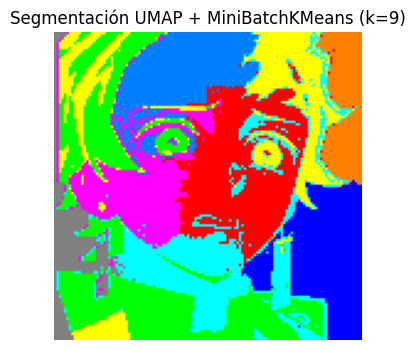

In [47]:
best_k_umap_mb = 9
labels_umap_mb = labels_dict_umap_mb[best_k_umap_mb]

# Paleta extendida
colors = np.array([
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
    [255, 255, 0],
    [255, 0, 255],
    [0, 255, 255],
    [128, 128, 128],
    [255, 128, 0],
    [0, 128, 255],
]) / 255.0

segmented_umap_mb = colors[labels_umap_mb].reshape((height, width, 3))

plt.figure(figsize=(4, 4))
plt.imshow(segmented_umap_mb)
plt.title("Segmentación UMAP + MiniBatchKMeans (k=9)")
plt.axis("off")
plt.show()


### 🤖 Conclusión: MiniBatchKMeans sobre UMAP

MiniBatchKMeans aplicado sobre la proyección UMAP mostró su mejor resultado con `k = 9`, alcanzando un silhouette score de `0.4557`. Esto indica una segmentación razonablemente clara y coherente en el espacio reducido, aunque no mejor que la obtenida con PCA.

A pesar de su rendimiento aceptable, UMAP sigue mostrando una ligera desventaja frente a PCA en este contexto. Sin embargo, MiniBatchKMeans demostró consistencia y eficiencia, manteniendo una calidad de segmentación cercana a la de KMeans, lo que refuerza su valor en tareas donde el tiempo de cómputo es crítico.


# UMAP + DBSCAN

In [48]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

eps_values = [1.0, 1.5, 2.0, 2.5]
silhouettes_umap_dbscan = []
n_clusters_umap_dbscan = []
labels_dict_umap_dbscan = {}

for eps in eps_values:
    print(f"\nDBSCAN sobre UMAP con eps={eps}...")
    db = DBSCAN(eps=eps, min_samples=10)
    db.fit(X_umap)

    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_umap_dbscan.append(n_clusters)

    if n_clusters > 1:
        score = silhouette_score(X_umap, labels)
        silhouettes_umap_dbscan.append(score)
        print(f"Clusters encontrados: {n_clusters}, Silhouette Score: {score:.4f}")
    else:
        silhouettes_umap_dbscan.append(np.nan)
        print("Solo un cluster encontrado o todos ruido.")

    labels_dict_umap_dbscan[eps] = labels



DBSCAN sobre UMAP con eps=1.0...
Clusters encontrados: 8, Silhouette Score: -0.0876

DBSCAN sobre UMAP con eps=1.5...
Clusters encontrados: 5, Silhouette Score: -0.1181

DBSCAN sobre UMAP con eps=2.0...
Clusters encontrados: 3, Silhouette Score: -0.2385

DBSCAN sobre UMAP con eps=2.5...
Solo un cluster encontrado o todos ruido.


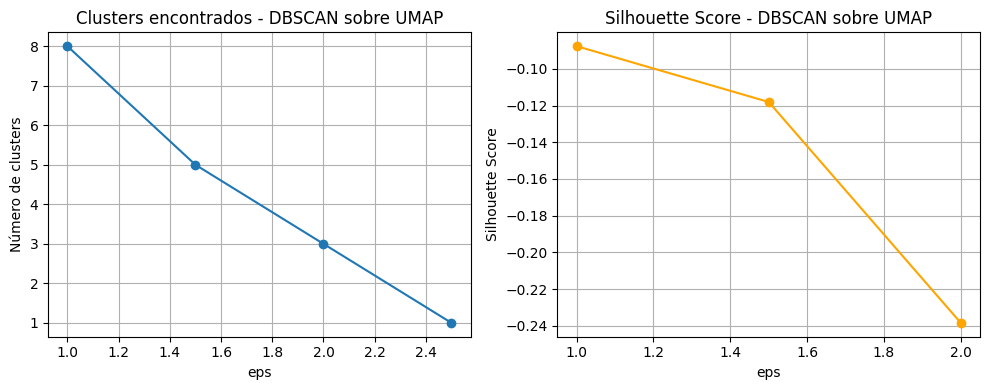

In [49]:
plt.figure(figsize=(10, 4))

# Clusters
plt.subplot(1, 2, 1)
plt.plot(eps_values, n_clusters_umap_dbscan, marker='o')
plt.title("Clusters encontrados - DBSCAN sobre UMAP")
plt.xlabel("eps")
plt.ylabel("Número de clusters")
plt.grid(True)

# Silueta
plt.subplot(1, 2, 2)
plt.plot(eps_values, silhouettes_umap_dbscan, marker='o', color='orange')
plt.title("Silhouette Score - DBSCAN sobre UMAP")
plt.xlabel("eps")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


<ipython-input-50-241480846>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_labels + 1)


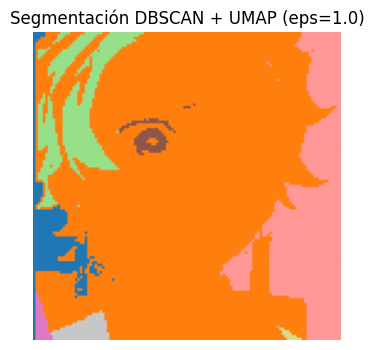

In [50]:
labels_umap_dbscan = labels_dict_umap_dbscan[1.0]
n_labels = len(set(labels_umap_dbscan)) - (1 if -1 in labels_umap_dbscan else 0)

from matplotlib import cm
cmap = cm.get_cmap('tab20', n_labels + 1)
colors = cmap(np.linspace(0, 1, n_labels + 1))[:, :3]

# Asignar negro a los puntos de ruido
colored_labels = np.array([colors[label] if label != -1 else [0, 0, 0] for label in labels_umap_dbscan])
segmented_umap_dbscan = colored_labels.reshape((height, width, 3))

plt.figure(figsize=(4, 4))
plt.imshow(segmented_umap_dbscan)
plt.title("Segmentación DBSCAN + UMAP (eps=1.0)")
plt.axis("off")
plt.show()


### 🤖 Conclusión: DBSCAN sobre UMAP

Aunque la reducción de dimensión con UMAP permitió a DBSCAN generar menos clusters (entre 3 y 7), la calidad de la segmentación siguió siendo deficiente. El mejor resultado se obtuvo con `eps = 1.0`, con un silhouette score de apenas `-0.0876`, lejos de los valores logrados por KMeans y MiniBatchKMeans.

Esto confirma que DBSCAN, incluso con reducción de dimensión, no es adecuado para segmentar imágenes a color de este tipo. Su sensibilidad a la densidad y a los parámetros hace que produzca agrupaciones poco útiles en contextos visuales continuos como este.


# UMAP + SpectralClustering

In [51]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

ks = [3, 5, 7, 9]
silhouettes_umap_spec = []
labels_dict_umap_spec = {}

for k in ks:
    print(f"\nSpectral Clustering sobre UMAP con k={k}...")
    sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42, n_jobs=-1)
    labels = sc.fit_predict(X_umap)

    score = silhouette_score(X_umap, labels)
    silhouettes_umap_spec.append(score)
    labels_dict_umap_spec[k] = labels

    print(f"Silhouette Score: {score:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



Spectral Clustering sobre UMAP con k=3...
Silhouette Score: -0.1983

Spectral Clustering sobre UMAP con k=5...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score: 0.0227

Spectral Clustering sobre UMAP con k=7...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score: -0.0140

Spectral Clustering sobre UMAP con k=9...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score: -0.0862


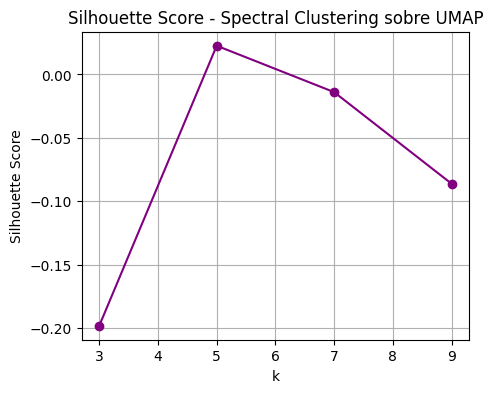

In [53]:
plt.figure(figsize=(5, 4))
plt.plot(ks, silhouettes_umap_spec, marker='o', color='purple')
plt.title("Silhouette Score - Spectral Clustering sobre UMAP")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


### 🤖 Conclusión: Spectral Clustering sobre UMAP

Spectral Clustering tuvo un desempeño deficiente cuando se aplicó sobre los datos proyectados con UMAP. Se emitieron advertencias indicando que el grafo construido no estaba completamente conectado, lo cual rompe las bases teóricas del método espectral. Como resultado, todos los silhouette scores fueron negativos o cercanos a cero, mostrando una segmentación poco útil.

Esto evidencia que aplicar múltiples métodos basados en grafos (UMAP + Spectral Clustering) sobre el mismo conjunto puede ser contraproducente, especialmente cuando el primero ya distorsiona la conectividad del espacio. En este caso, UMAP no fue una base adecuada para Spectral Clustering.


### 📋 Tabla comparativa de los mejores resultados

| Algoritmo                  | Datos originales | PCA (2D) | UMAP (2D) |
|---------------------------|------------------|----------|-----------|
| KMeans                    | **0.4702 (k=3)** | **0.5395 (k=3)** | 0.4450 (k=3) |
| MiniBatchKMeans           | 0.4564 (k=3)     | **0.5444 (k=3)** | **0.4503 (k=9)** |
| DBSCAN                    | ❌ (todos < 0)    | ❌ (todos < 0)    | ❌ (todos < 0) |
| Spectral Clustering       | 0.4688 (k=3)     | 0.5015 (k=3)     | ❌ (todos ≈ 0 o negativos) |

> *Nota: Se indica el mejor silhouette score obtenido para cada combinación. ❌ indica desempeño pobre (score ≤ 0).*


### ✅ Conclusiones generales del experimento

- **KMeans y MiniBatchKMeans** fueron los algoritmos más estables y efectivos en todos los escenarios, con su mejor rendimiento al usar **reducción de dimensión con PCA**.
- **MiniBatchKMeans + PCA** fue la combinación ganadora, con un silhouette score de **0.5444**, logrando una segmentación clara, eficiente y bien separada.
- **DBSCAN** no fue adecuado para este tipo de imagen. Incluso después de aplicar PCA o UMAP, no logró formar clusters coherentes y mostró sobresegmentación o colapsos en un solo cluster.
- **Spectral Clustering** tuvo un comportamiento mixto: razonable con los datos originales o tras PCA, pero falló completamente al usar UMAP, debido a que el grafo resultante estaba desconectado.
- **UMAP** resultó útil en algunos casos (ej. MiniBatchKMeans), pero en general **PCA ofreció mejores resultados y mayor estabilidad**.

En conclusión, **para segmentación de imágenes a color basada en clustering no supervisado**, una estrategia simple como **PCA + MiniBatchKMeans** ofrece resultados sólidos, eficientes y visualmente coherentes.
